# Generate .csv files for CNN

## Imports and Constants

In [2]:
import math
import sys
import os
from collections import defaultdict
from itertools import combinations

import numpy as np
from scipy.io import wavfile
from scipy import signal
import pandas as pd

import tensorflow as tf
from keras import Sequential
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Conv1D
from keras.layers import MaxPooling1D

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

import pyroomacoustics as pra
from pyroomacoustics.utilities import normalize
from pyroomacoustics.transform import stft

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler

# Label resolution of angles
RESOLUTION = 50

# Number of samples to include while creating one ML feature
SAMPLES = 2048

# Determines the overlap of samples between consecutive features
STEP = 1024

# Training rooms dimensions
ROOMS = {
    'small' : np.array([4, 4, 3]),
    'medium' : np.array([6, 6, 3]),
    'large' : np.array([8, 8, 3])
}

# Testing rooms dimensions
TEST_ROOMS = {
    'small' : np.array([5, 5, 2]),
    'medium' : np.array([7, 7, 2]),
    'large' : np.array([9, 9, 2])
}

AUDIO_PATH = 'C:\\Users\\Alex\\source\\repos\\sound-localization\\data'

# Number of microphones
MICS_NUMBER = 2
MIC_COMBS = len(list(combinations(range(MICS_NUMBER), 2)))

## Utils

In [ ]:
def plot_cm(y_true, y_pred, class_names, font_scale=0.8):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    
    fig, ax = plt.subplots(figsize=(24, 20)) 
    ax = sns.heatmap(cm, annot=True, fmt=".3f", ax=ax)

    plt.ylabel('Actual', fontsize=24)
    plt.xlabel('Predicted', fontsize=24)
    plt.show()
    
    
def rmse(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    total = sum(min(abs(y_t - y_p), (360 - abs(y_t - y_p))) ** 2 for y_t, y_p in zip(y_true, y_pred))
    rms = ((total / len(y_true)) ** 0.5)
    
    if type(rms) == np.ndarray:
        rms = rms[0]
        
    return round(rms, 3)

In [ ]:
def one_hot_encode(encoder, y_train, y_test):    
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)
    
    # One-hot encode training and testing labels
    enc = encoder.fit(y_train)
    y_train = enc.transform(y_train)
    y_test = enc.transform(y_test)
    
    return y_train, y_test


def create_whole_dataset(df_train, df_test, encoder, room=None, dist=None):
    if room:
        df_test = df_test[df_test.room == room]
    if dist:
        df_test = df_test[df_test.dist == dist]
    
    # Create train/test observations
    X_train = df_train.drop(columns=['dist', 'room', 'label']).values.reshape(
        len(df_train), MIC_COMBS, -1)
    X_test = df_test.drop(columns=['dist', 'room', 'label']).values.reshape(
        len(df_test), MIC_COMBS, -1)
    
    # Create train/test labels
    y_train, y_test = one_hot_encode(
        encoder, df_train['label'].values, df_test['label'].values)
    
    return X_train, y_train, X_test, y_test

In [ ]:
df_train = pd.read_csv('../training_data/azimuth_train_dataset.csv', index_col=[0])
df_test = pd.read_csv('../training_data/azimuth_test_dataset.csv', index_col=[0])

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoder.fit([[label] for label in df_train['label']])
X_train, y_train, X_test, y_test = create_whole_dataset(df_train, df_test, encoder)

C:\Users\Alex\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Alex\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1416, 1, 11), (1416, 8), (1416, 1, 11), (1416, 8))

## CNN

In [ ]:

# Transpose the observations because Conv1D requires timesteps as the 1st dim
X_train, X_test = np.transpose(X_train, axes=[0, 2, 1]), np.transpose(X_test, axes=[0, 2, 1])

X_train.shape, X_test.shape

((1416, 11, 1), (1416, 11, 1))

In [ ]:
# Fit model
epochs, batch_size, verbose = 100, 32, 1

def create_model(X_train, y_train):
    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

    # Init model
    model = Sequential()

    # Add layers
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features), padding='same'))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())   # 1D array
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))    # 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
    
    return model, history

In [ ]:
model, history = create_model(X_train, y_train)
np.save('../models/history.npy', history.history)

Epoch 1/200
45/45 [==============================] - 1s 4ms/step - loss: 1.7962 - accuracy: 0.3136
Epoch 2/200
45/45 [==============================] - 0s 4ms/step - loss: 1.1091 - accuracy: 0.5346
Epoch 3/200
45/45 [==============================] - 0s 4ms/step - loss: 0.8200 - accuracy: 0.6455
Epoch 4/200
45/45 [==============================] - 0s 4ms/step - loss: 0.6985 - accuracy: 0.7062
Epoch 5/200
45/45 [==============================] - 0s 4ms/step - loss: 0.6438 - accuracy: 0.7352
Epoch 6/200
45/45 [==============================] - 0s 3ms/step - loss: 0.5723 - accuracy: 0.7655
Epoch 7/200
45/45 [==============================] - 0s 3ms/step - loss: 0.5277 - accuracy: 0.7797
Epoch 8/200
45/45 [==============================] - 0s 3ms/step - loss: 0.4790 - accuracy: 0.8001
Epoch 9/200
45/45 [==============================] - 0s 3ms/step - loss: 0.4498 - accuracy: 0.8086
Epoch 10/200
45/45 [==============================] - 0s 4ms/step - loss: 0.4311 - accuracy: 0.8171
Epoch 11/

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 11, 64)            256       
                                                                 
 conv1d_3 (Conv1D)           (None, 11, 64)            12352     
                                                                 
 dropout_1 (Dropout)         (None, 11, 64)            0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 11, 64)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 704)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               70500     
                                                      

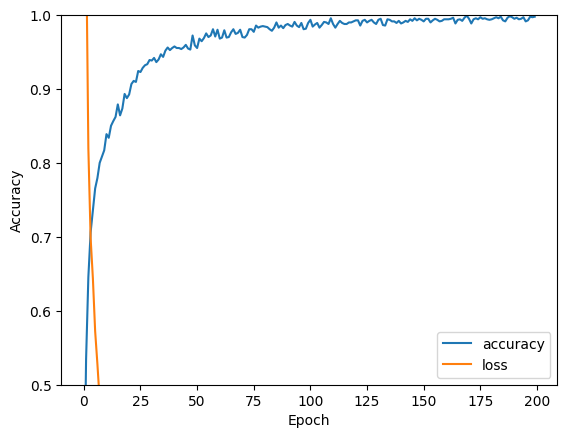

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label = 'loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

45/45 [==============================] - 0s 2ms/step


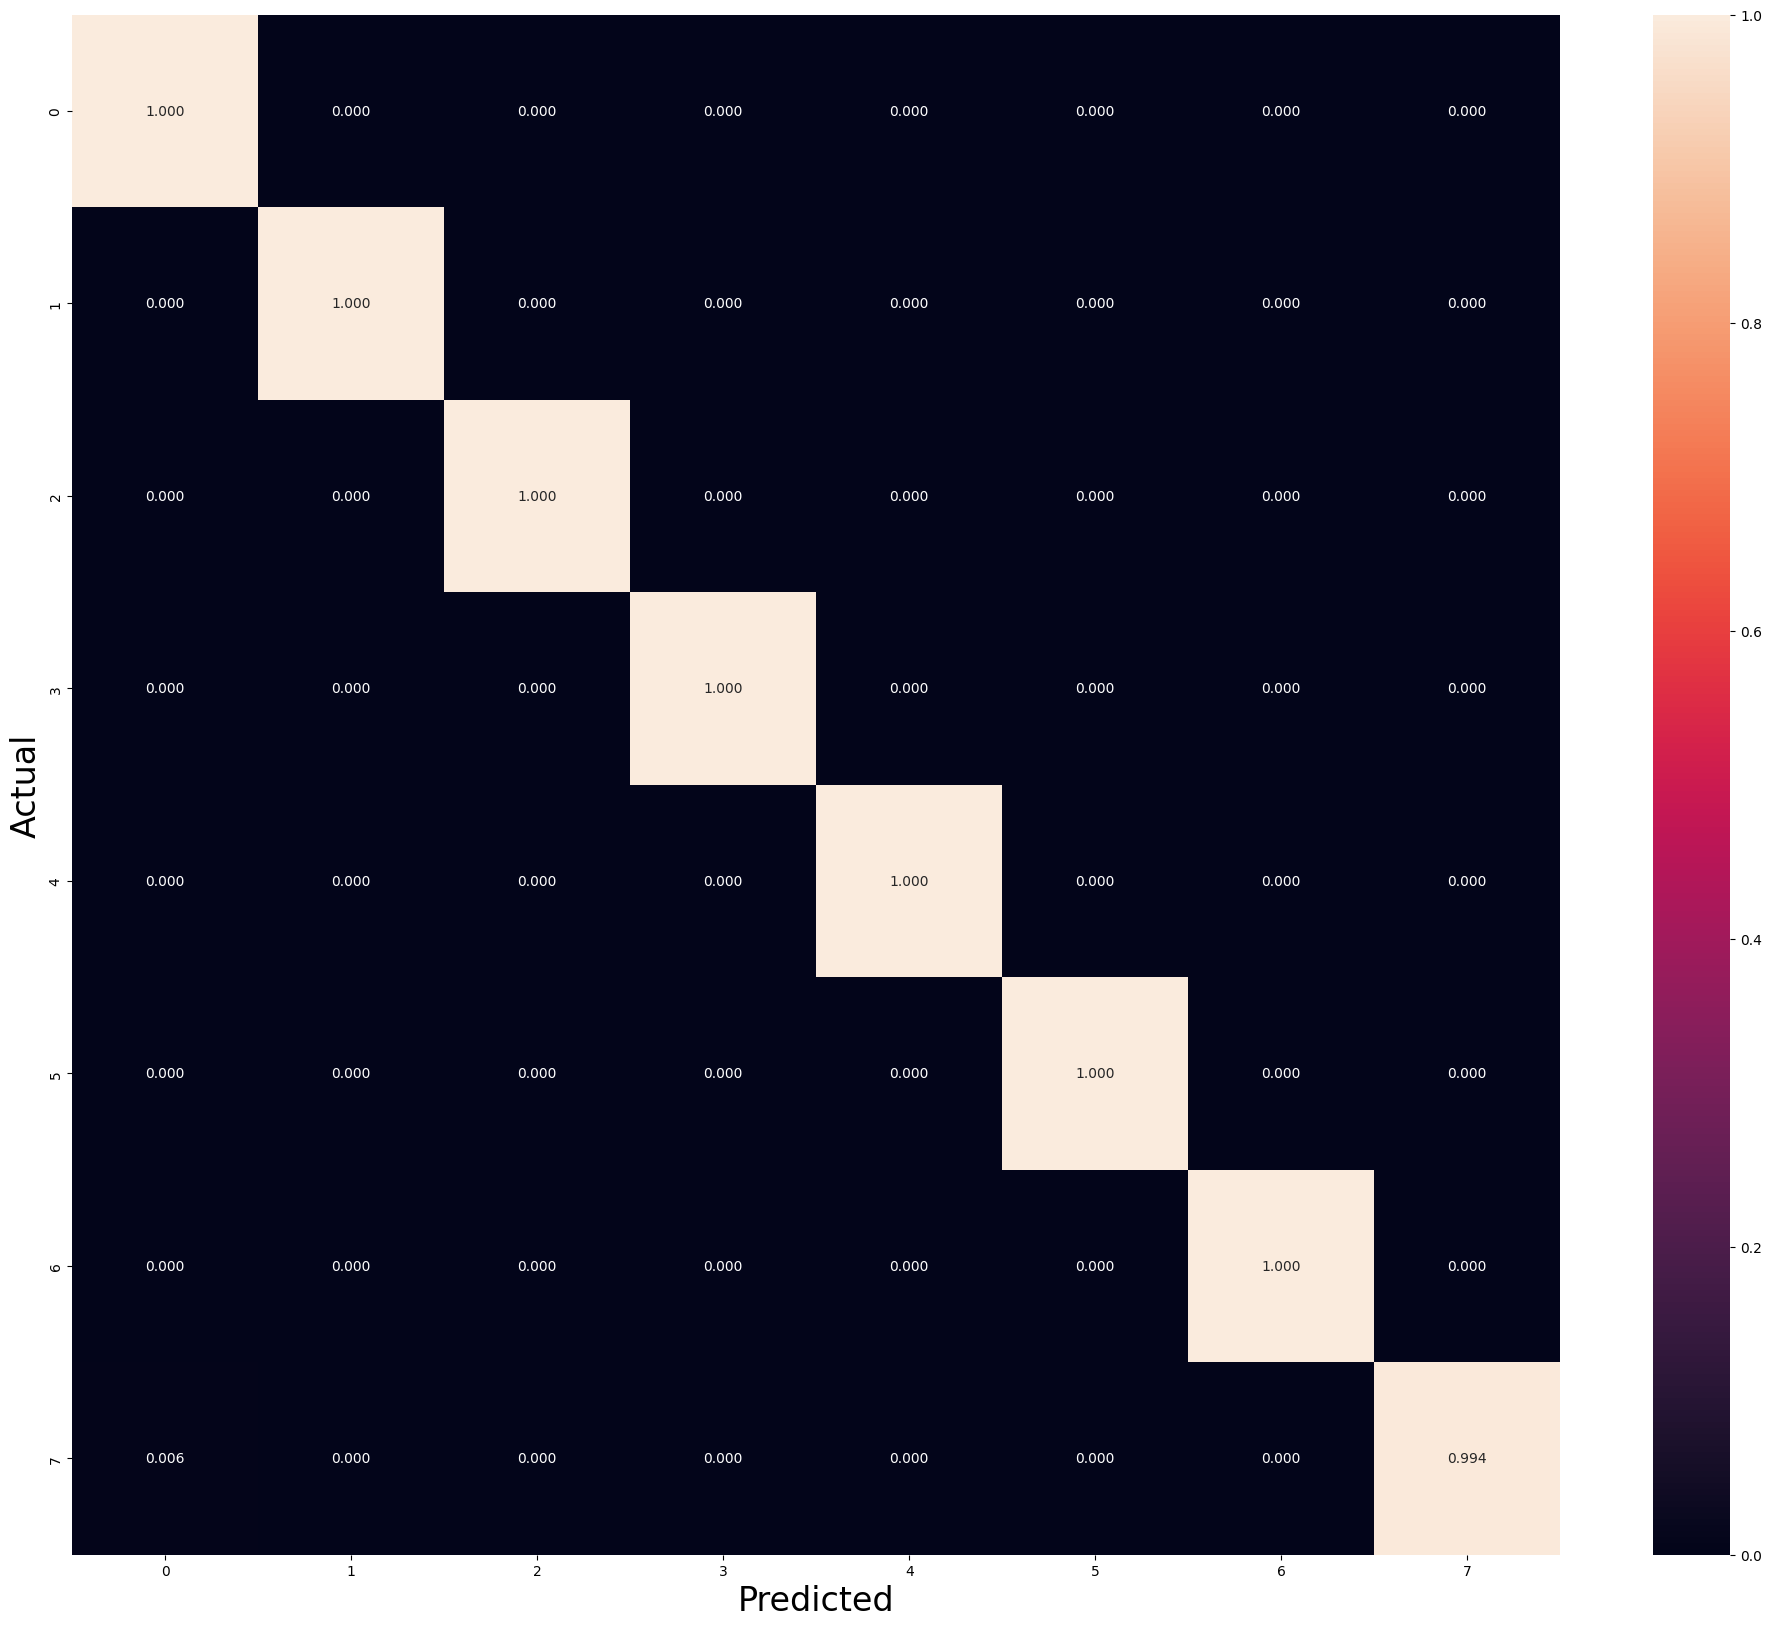

Accuracy: 0.999
RMSE: 0.266


In [ ]:
# Test model
loss, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=verbose)

y_pred_nn = model.predict(X_test)
y_pred_nn = encoder.inverse_transform(y_pred_nn)
y_true_nn = encoder.inverse_transform(y_test)
plot_cm(y_true_nn, y_pred_nn, np.unique(y_true_nn))
print(f'Accuracy: {round(accuracy, 3)}')
print(f'RMSE: {rmse(y_true_nn, y_pred_nn)}')

In [1]:
plt.plot(history.history['val_loss'], label='accuracy')
plt.plot(history.history['loss'], label = 'loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

NameError: name 'plt' is not defined